__Seções:__<br>
* <a href='#itemA'>Seção A</a> <br>
* <a href='#itemB'>Seção B</a> <br>
* <a href='#itemC'>Seção C</a> <br>
    * <a href='#itemC1'>Seção C.1</a> <br>
    * <a href='#itemC2'>Seção C.2</a> <br>
    * <a href='#itemC3'>Seção C.3</a> <br>
    * <a href='#itemC4'>Seção C.4</a> <br>
* <a href='#itemD'>Seção D</a> <br>
* <a href='#itemE'>Seção E</a> <br>
* <a href='#itemF'>Seção F</a> <br>

In [51]:
####################################################################
###################### Importando Bibliotecas ######################
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import matplotlib
import statsmodels.api as sm
from random import randint
from scipy import stats
from sklearn import linear_model
import pandas as pd
import numpy as np
import itertools
import requests
import math
import re
import os
import seaborn as sb


from sklearn.model_selection import train_test_split

####################################################################
#################### Funções Preparar Databases ####################

#Recebe uma URL e retorna o código HTML da página
def baixarhtml(url):
    html = requests.get(url).text.splitlines()
    return html

#Recebe lista de URLs do Buscape e o nome de cada variável e retorna um Dataframe 
def gerarBD(lista):
    table = dolar.copy()
    
    for num in range(len(lista)):
        produto, url = lista[num][0], lista[num][1]
        
        #Pega ID do produto do buscape usando a url fornecida
        code = baixarhtml(url)
        for num_linha in range(len(code)):
            match = re.findall('"productId":[0-9]*', code[num_linha])
            if len(match)>0:
                id = match[0].split(':')[1]

        #Baixa BD dos preços
        code = baixarhtml("https://www.buscape.com.br/async/history/idu/" + id + "/days/365")

        #Pega só a parte dos dados e cria tabela bd
        bd = pd.read_json(code[0].split('"historicos":')[1][:-1])

        #Converte data pro formato e define essa coluna como índice
        bd['data'] = pd.to_datetime(bd['data'],  format='%d/%m/%Y')
        bd.set_index(bd['data'], inplace=True)
        
        #Adiciona a coluna com o nome do produto o preço do produto
        table[produto] = bd.loc[:,['precomed']]
        table[produto] = table[produto].astype(float)
    
    table = table.dropna(how='any') # Tira linha que tiver algum valor NaN
    return table


####################################################################
############################# Funções : #############################

def regressao(lX,lY):
    Xreg = sm.add_constant(lX)
    model = sm.OLS(lY,Xreg)
    results = model.fit()
    return results

#Função retorno
def func_retorno(n,n_ant):
    val = 0
    if n_ant == 0:
        print('tem zero')
    else:
        val = math.log(n/n_ant)
    return val

#Coeficiente de Deterinação R2
def R2(Ydados, Ypred):
    Scima, Sbaixo = 0,0
    YmedioDados = np.mean(Ydados)
    
    for i in range(len(Ypred)):
        Scima += (Ydados[i] - Ypred[i])**2
        Sbaixo += (Ydados[i] - YmedioDados)**2
    
    Rdois = 1- Scima/Sbaixo
    return Rdois

####################################################################
######## Funções que existem em bibliotecas mas que criei: ########

# RMS = Erro Quadrático Médio (Mean Squared Error) (testada)
# O mesmo que: math.sqrt(mean_squared_error(orig, pred)
def rms(orig, pred):
    n, soma = len(orig), 0
    
    for i in range(n):
        soma += (orig[i] - pred[i])**2
    
    val = round(math.sqrt(soma/n),8)
    return val


# MMQ = Método dos Mínimos Quadrados (Least squares) (testada)
def mmq(lX,lY):
    mediaX, mediaY = np.mean(lX), np.mean(lY)

    Sxx, Sxy = 0, 0
    for num in range(len(lX)):
        deltaX, deltaY = (lX[num] - mediaX), (lY[num] - mediaY)
        Sxx += deltaX **2
        Sxy += deltaX * deltaY

        b1 = Sxy/Sxx
        b0 = mediaY - b1*mediaX

    return [b0,b1]


___
# Ciência dos Dados - PROJETO 3 - INSPER
___
### Mariana Abrantes, Gabriel Couto e Gabriel Miras
___

# Previsão do preço do Iphone X através do preço do dólar e de outros 7 smartphones do mercado

<a id='itemA'></a>
___

## A. INTRODUÇÃO

Nestes últimos anos, com a instabilidade política e socioeconômica do Brasil, o preço do dólar está em constante variação. Consequentemente, os valores sobre produtos estrangeiros também mudam. Além disso, o preço de outros dispositivos do mercado podem influenciar no preço de um outro produto. Ao visualizar esse cenário, gostaríamos de analisar a influência da alteração do valor do dólar, de 3 aparelhos da Apple e de 4 aparelhos da Samsung sobre o preço do Iphone X. <br>
<br>
__Variável Dependente (resposta) - Y : Preço do Iphone X__ (Váriavel de interesse cujo comportamento se deseja explicar)<br>
__Variável Independente (explicativa) - X: Dolar e o preço dos outros celulares__ (Usadas para explicar Y)<br>

<a id='itemB'></a>
___

## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

___
### B.1) Minerando Dados

__Preço do Dólar__ <br>
&emsp;O DataFrame foi obtido no [site](https://economia.uol.com.br/cotacoes/cambio/dolar-comercial-estados-unidos/) através do [link](https://api.cotacoes.uol.com/currency/interday/list/years/?format=JSON&fields=askvalue,date&currency=1) em JSON e foi filtrado da seguinte forma:
 * a) Definimos a coluna 'Data' como índice da tabela
 * b) Pegamos apenas a coluna 'Compra' com o preço do dolar no dia e o índice das linhas
 * c) Definimos a coluna 'Compra' do tipo float e renomeamos ela pra "Dolar"
 
__Tabela de Preços dos Smartphones__ <br>
Os dados de cada celular foram retirados do histórico de preço médio do site buscape. <br>
* a) A função gerarBD() recebe uma lista com nome e url do celular para retornar um Dataframe de preço dos celulares e do dolar por dia.<br>
Para cada linha da lista:
    * 1) Cria uma cópia do Dataframe dolar chamado table
    * 2) Baixa o código da url fornecida e captura o ID do produto
    * 3) Com o ID baixamos o histórico de preço médio do aparelho em JSON e criamos o Dataframe bd com ele
    * 4) Usamos .join para unir as colunas num novo dataframe
    * 5) Definimos a coluna 'Data' como do tipo datetime e em seguida definimos essa coluna como índice da tabela<br>
* b) Removemos as linhas que possuam ao menos um valor vazio e retornamos essa nova tabela como resultado da função

In [2]:
links = [
    ['Iphone X',          "https://www.buscape.com.br/smartphone-apple-iphone-x-64gb"],
    ['Iphone 8 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-8-plus-64gb"],
    ['Iphone 7',          "https://www.buscape.com.br/smartphone-apple-iphone-7-32gb"],
    ['Iphone 7 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-7-plus-128gb"],
    ['Galaxy S8',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-sm-g950-64gb"],
    ['Galaxy S8 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-plus-sm-g955-128gb"],
    ['Galaxy S9',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-sm-g960-128gb"],
    ['Galaxy S9 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-plus-sm-g965-128gb"]
]

__Carregando ou gerando e salvando  os dados para não precisar baixar e criar o dataframe a cada execução do código__<br>
Se não houver o arquivo tabela.csv na pasta executa a função gerarBD() e salva o dataframe como tabela.csv, se já houver o arquivo tabela.csv carrega ele como tabela.

In [3]:
#Se já tiver um arquivo tabela.csv salvo carrega ele, se não cria a tabela e salva ela
exists = os.path.isfile('tabela.csv')
if exists:
    tabela = pd.read_csv('tabela.csv', sep=",")
    tabela.index = tabela['data']
    tabela = tabela.loc[:,list(tabela.columns)[1:]]
else:
    #baixar e botar em dataframe preço do dolar em real
    codeDolar = baixarhtml('https://api.cotacoes.uol.com/currency/interday/list/years/?format=JSON&fields=askvalue,date&currency=1')
    bdDolar = codeDolar[0].split('"docs":')[1][:-1]
    bdDolar = re.sub('000000"}'  ,'"}', bdDolar)
    dfDolar = pd.read_json(bdDolar)
    dfDolar.columns = ['Dolar','Data']
    dfDolar['Data'] = pd.to_datetime(dfDolar['Data'],  format='%Y%m%d')
    dfDolar.index = dfDolar['Data']
    dolar = dfDolar[['Dolar']]

    #gera tabela
    tabela = gerarBD(links)
    tabela.to_csv('tabela.csv')

tabela.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
data,,,,,,,,,
2018-05-22,5791.4575,4019.5854,3033.4468,3491.2202,3050.4950,4085.785,3956.2925,4479.7305,3.6447
2018-05-23,5853.7800,4057.0140,3043.2737,3406.8965,3061.1514,3672.570,3966.1755,4490.3880,3.6251
2018-05-24,5885.4900,3896.7625,2852.5547,3444.2380,2992.7668,4028.438,3966.7402,4502.2856,3.6483


___
### B.2) Características do Dataset

No site que coletamos os dados sobre os preços de cada aparelho, está reunida informações a respeito de seus preços médios,mais baixo e mais elevado do último ano. Mas apenas utilizamos o preço médio.
Já o dataset sobre a cotação do dólar, o período é de janeiro de 2018 até maio de 2019. Mas existem dias em que ele não variou, portanto nós limpamos as bases de dados tanto do telefone como do dólar, para obter o cenário mais próximo da realidade.

### __Calculamos o retorno de cada variável__ <br>
O cálculo do retorno de cada dia corresponde ao logaritmo natural do preço do produto no dia n+1 dividido pelo preço do produto no dia n. <br> $$retorno = \ln \Big(\dfrac{P_{n+1}}{P_{n}}\Big)$$

In [23]:
df = tabela.copy()

#Cria coluna com o valor da linha anterior
for coluna in tabela.columns:
    df[coluna+'-1'] = df[coluna].shift(1)

df = df.iloc[1:,:] # Tira primeira linha (perdida pra fazer deltas)

dic={}
for coluna in tabela.columns:
    lis,ind=[],[]
    for index, row in df.iterrows():
        retor = func_retorno(row[coluna],row[coluna+'-1'])
        lis.append(retor)
        ind.append(index)
    dic[coluna]=lis

retorno = pd.DataFrame(data=dic,index=ind)

In [24]:
retorno.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
2018-05-23,0.010704,0.009268,0.003234,-0.024450,0.003487,-0.106622,0.002495,0.002376,-0.005392
2018-05-24,0.005402,-0.040301,-0.064719,0.010901,-0.022593,0.092487,0.000142,0.002646,0.006379
2018-05-25,-0.001517,0.031066,0.045622,0.007526,0.044937,-0.088895,0.010331,-0.007334,0.005467


### ANÁLISE DESCRITIVA

Em nossa base de dados buscamos os preços de telefones das marcas Apple e Samsung, sendo eles Iphone X, Iphone 8 Plus, Iphone 7 plus, iphone 7, Galaxy S8, Galaxy S8 Plus, Galaxy S9 e Galaxy S9 Plus. Como nosso objetivo é entender a influência do dólar e dos outros 7 aparelhos sobre o preço do Iphone X, vamos observar a correlação destes elementos sobre o nosso objetivo.

In [25]:
#Correlação
retorno.corr()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
Iphone X,1.000000,0.077340,0.153120,0.150596,0.074914,0.057238,0.153962,0.105623,-0.000626
Iphone 8 Plus,0.077340,1.000000,0.134727,0.199152,0.086202,-0.018669,0.091178,0.017414,-0.014322
Iphone 7,0.153120,0.134727,1.000000,0.377102,-0.063667,-0.016796,-0.120391,-0.001215,-0.045196
Iphone 7 Plus,0.150596,0.199152,0.377102,1.000000,0.007376,-0.022155,-0.021023,-0.040070,0.079599
Galaxy S8,0.074914,0.086202,-0.063667,0.007376,1.000000,-0.063318,0.143817,0.146873,-0.078579
Galaxy S8 Plus,0.057238,-0.018669,-0.016796,-0.022155,-0.063318,1.000000,-0.123022,-0.115546,-0.039319
Galaxy S9,0.153962,0.091178,-0.120391,-0.021023,0.143817,-0.123022,1.000000,0.319579,0.049093
Galaxy S9 Plus,0.105623,0.017414,-0.001215,-0.040070,0.146873,-0.115546,0.319579,1.000000,0.032512
Dolar,-0.000626,-0.014322,-0.045196,0.079599,-0.078579,-0.039319,0.049093,0.032512,1.000000


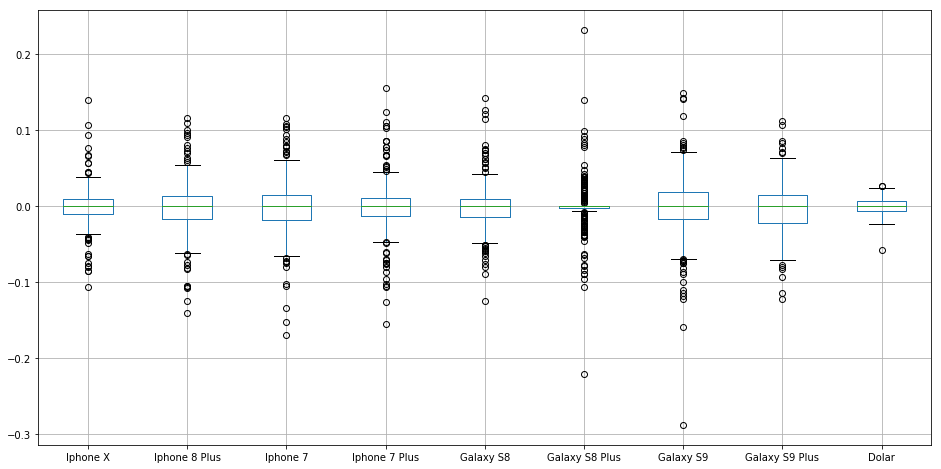

In [26]:
retorno.boxplot(column=list(retorno.columns), fontsize=10, grid=True, figsize= (16,8))

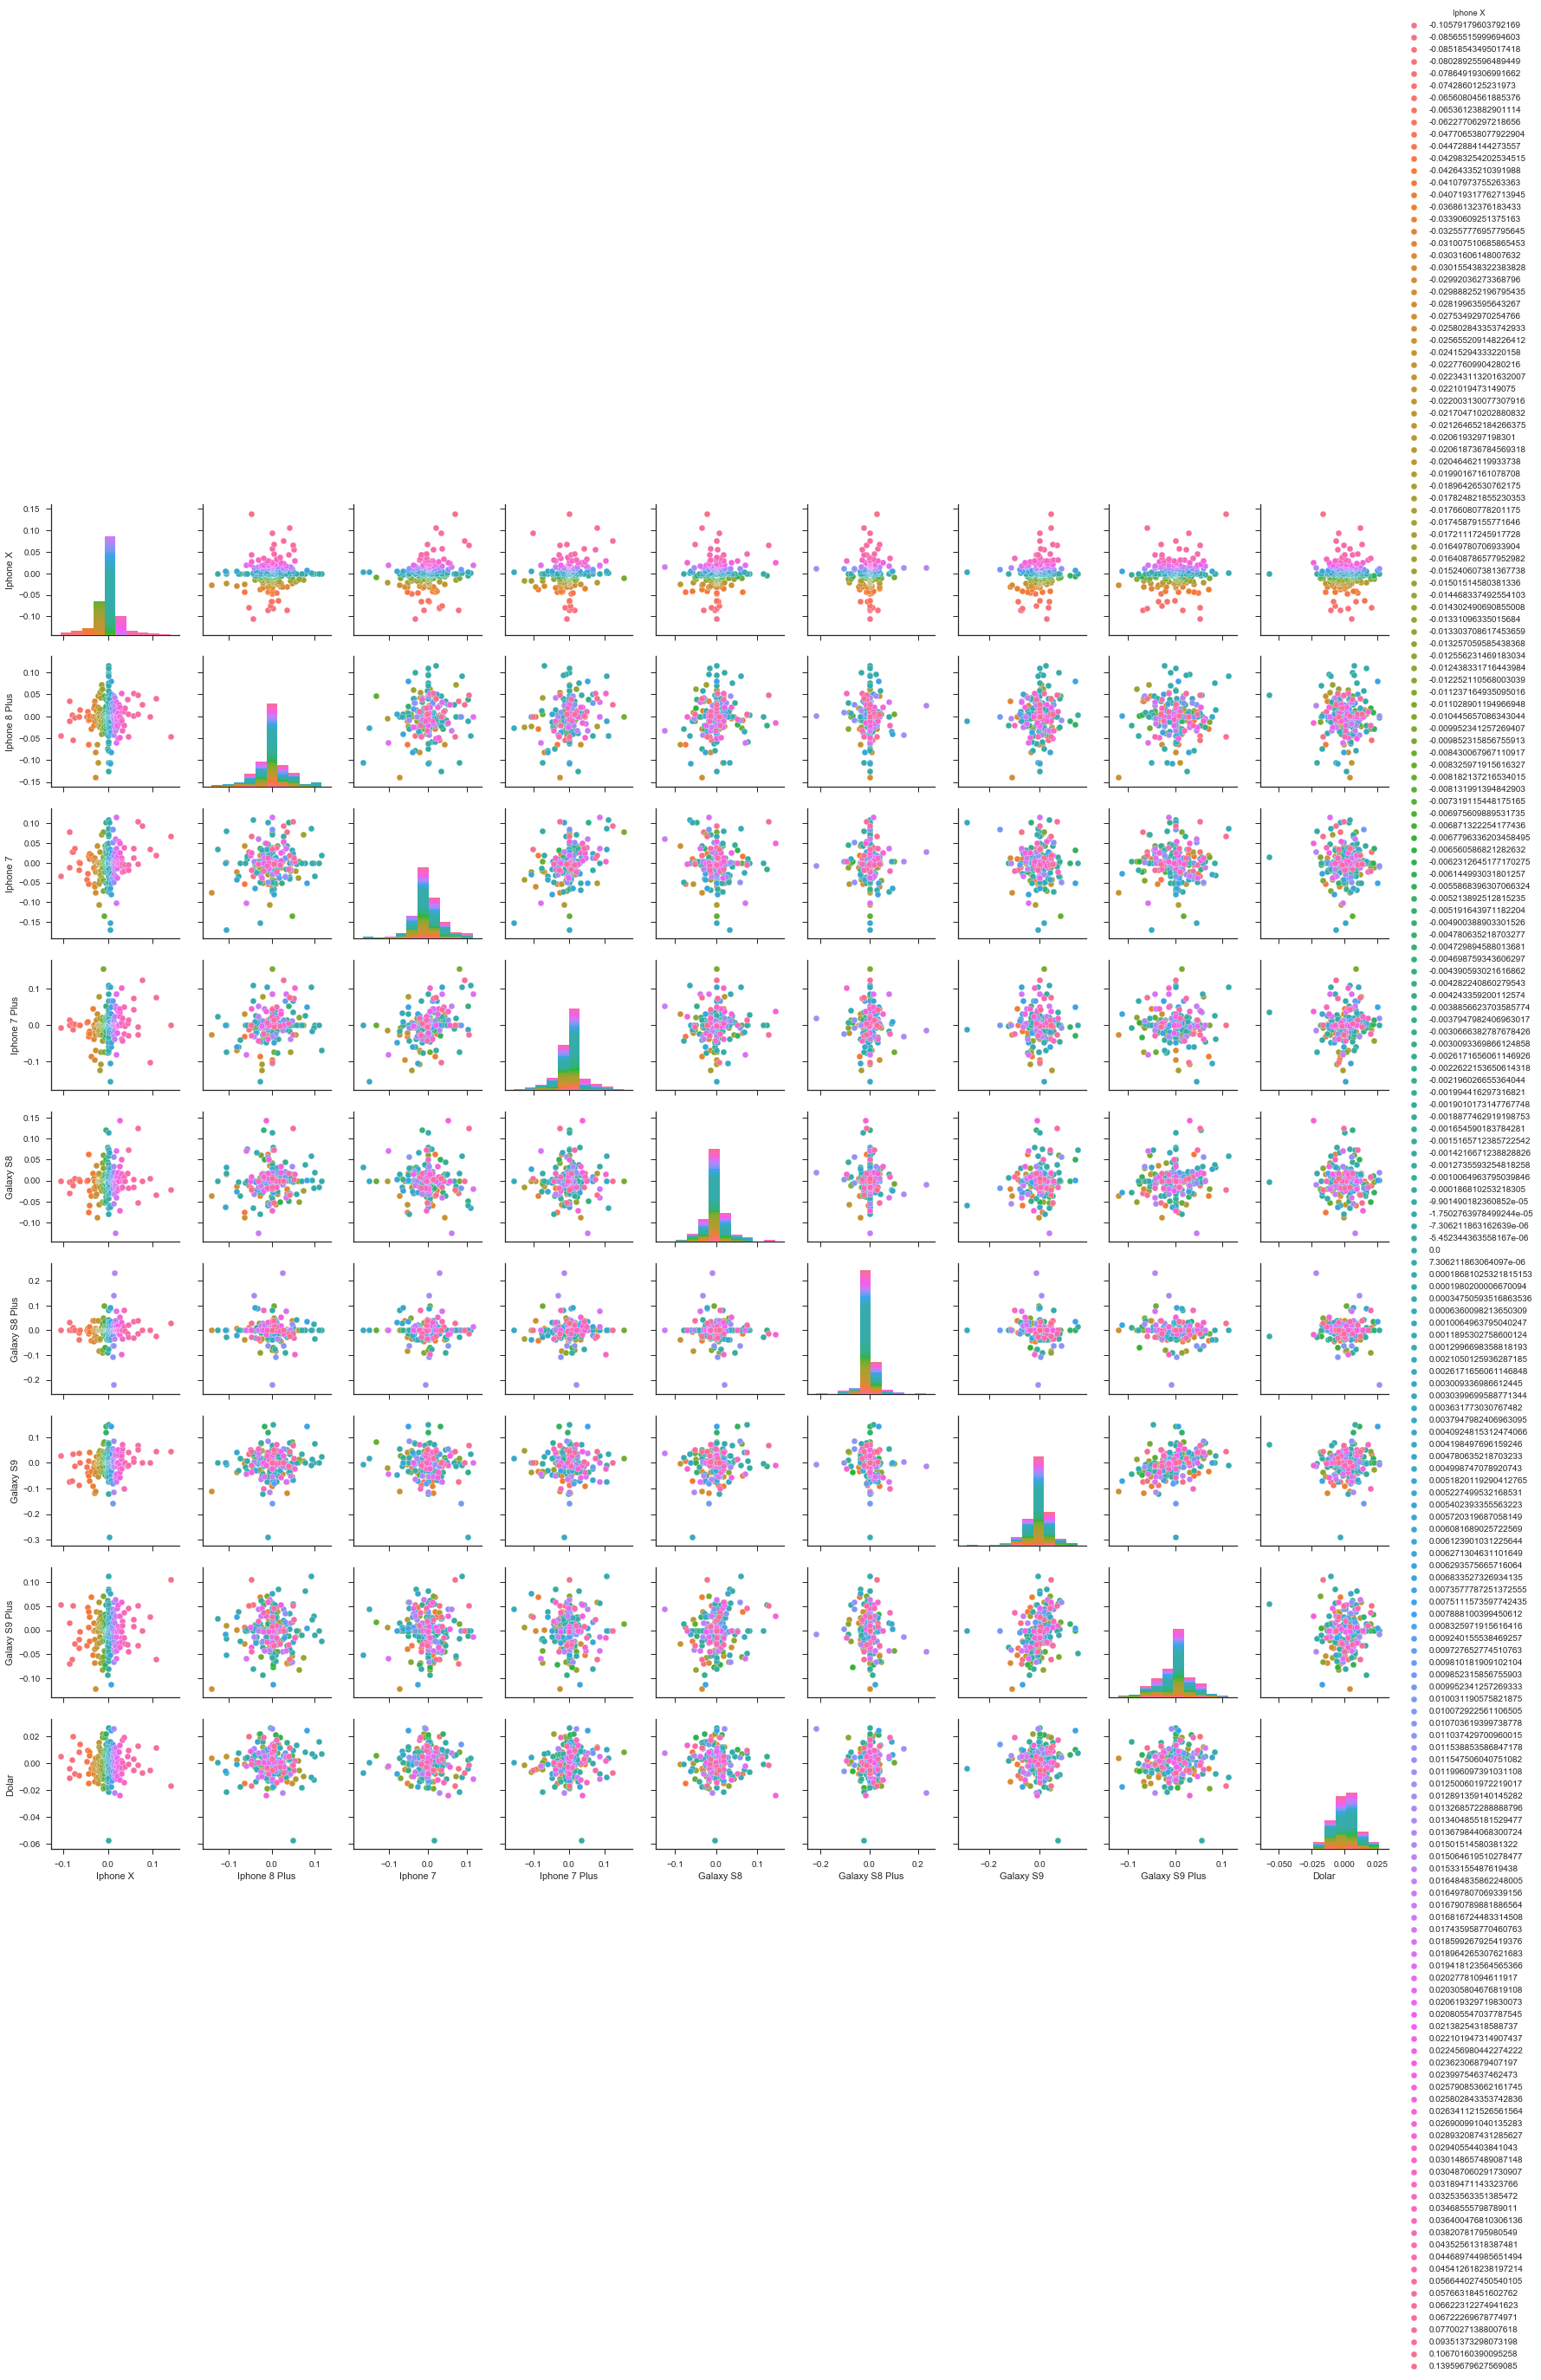

In [27]:
sb.set(style="ticks")
sb.pairplot(retorno, hue='Iphone X');

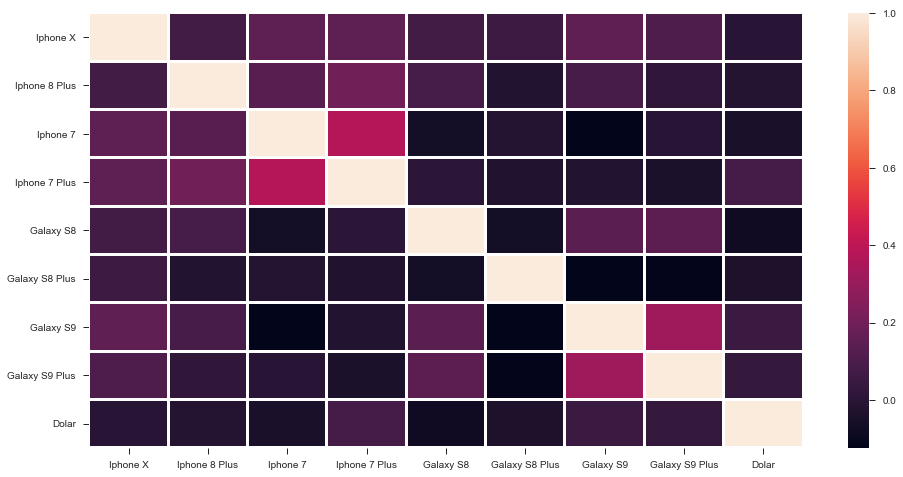

In [29]:
plt.figure(figsize=(16, 8))
sb.heatmap(retorno.corr(), linewidth=2);

Podemos observar que a correlação entre os dados, são extremamente baixo, podendo concluir que estes não possuem uma correlação relevânte. Mas os únicos aparelhos que apresentaram um grau maior de correlação foram o Iphone 7 com o Iphone 7 Plus e o Samsung S9 com o S9 Plus, pois apresentam apenas uma diferença de tamanho.

__Análise Univariada:__ <br>

Histograma das variáveis:

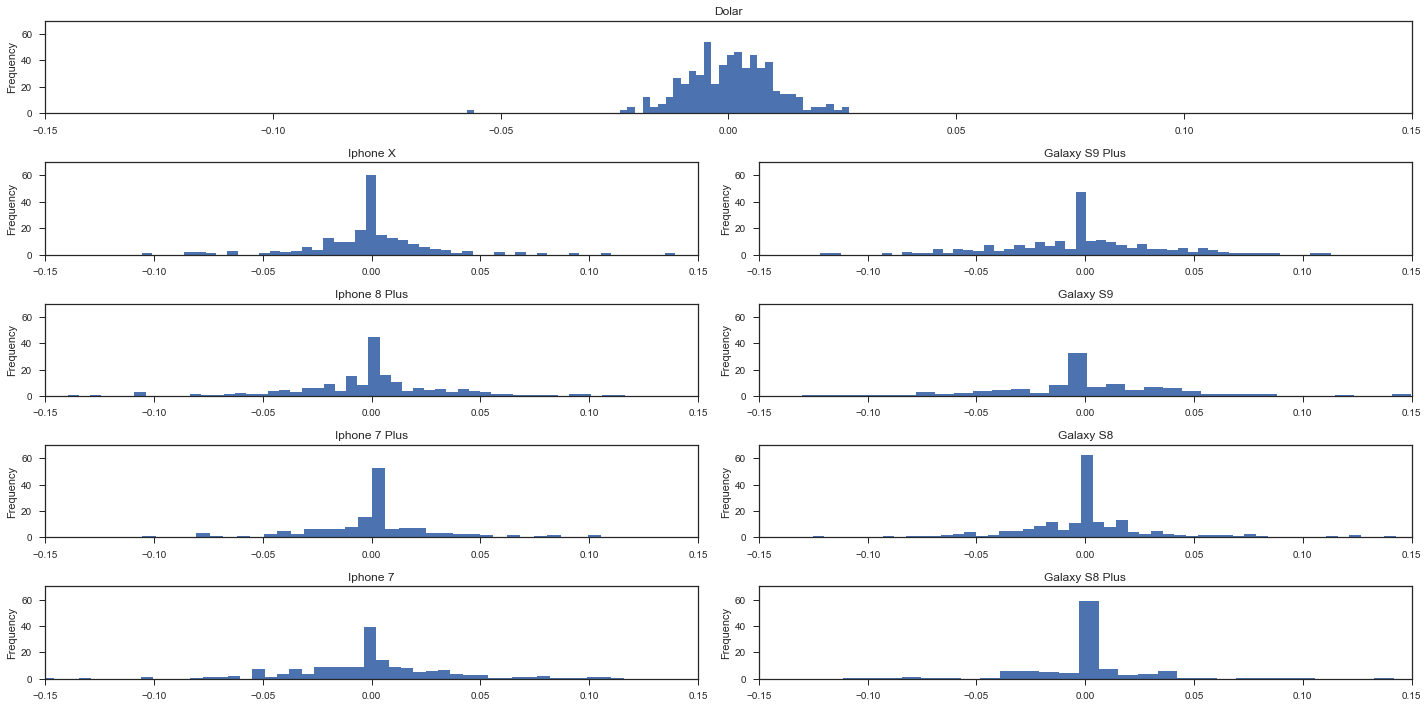

In [32]:
#Limites do gráfico:
xlim, ylim = [-0.15,0.15], [0,70] 

#Dita a ordem que os grpaficos vão aparecer
labels0 = ['Iphone X','Iphone 8 Plus','Iphone 7 Plus','Iphone 7']
labels1 = ['Galaxy S9 Plus', 'Galaxy S9', 'Galaxy S8', 'Galaxy S8 Plus']
labels = [labels0, labels1]

fig = plt.figure(figsize=(20,10)) #largura da linha,altura da linha

#Dolar
plt.subplot2grid((5, 2), (0, 0), colspan=2)
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
retorno['Dolar'].plot.hist(bins=50, title='Dolar', density=True);        

#Outras colunas
for n_y in [0,1]:
    for n_x in [1,2,3,4]:
        ax = plt.subplot2grid((5, 2), (n_x, n_y))
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
        retorno[labels[n_y][n_x-1]].plot.hist(bins=50, title=labels[n_y][n_x-1], density=True);        
        
plt.tight_layout()
plt.show()

# Descriçao análise 

In [33]:
retorno.describe()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,-0.000685,-0.000602,-0.000735,-0.000399,0.000195,-0.000530,-0.001418,-0.001577,0.000487
std,0.027221,0.037024,0.039242,0.038225,0.032000,0.035385,0.046012,0.035720,0.010096
min,-0.105792,-0.139795,-0.168720,-0.155254,-0.125202,-0.220123,-0.287738,-0.121702,-0.057482
25%,-0.009877,-0.017007,-0.017809,-0.012172,-0.014437,-0.002575,-0.016352,-0.021492,-0.005729
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000816
75%,0.009362,0.013035,0.014530,0.010819,0.009213,0.000000,0.018929,0.015022,0.006601
max,0.139597,0.116284,0.115890,0.155254,0.142910,0.232399,0.149577,0.112801,0.026513


<a id='itemC'></a>
___

## C. MODELOS DE PREDIÇÃO



Os modelos de predição que foram utilizados foram:

$\rightarrow$ Modelo de predição pela Média;

$\rightarrow$ Modelo de Regressão Linear Múltipla

$\rightarrow$ Modelo de Regressão dos K Vizinhos Mais Próximos

$\rightarrow$ Árvore de Regressão 

Os modelos foram explicados nos itens seguintes acompanhados de seus resultados. O objetivo é comparar o desempenho das diferentes técnicas, a fim de encontrar a melhor opção que se ajusta ao objetivo do trabalho.


__Separando a tabela em teste e treinamento__

In [34]:
# colRes = Coluna Resposta (Dependente)
colRes = 'Iphone X'

# colExp = Lista de Colunas Explicativas (Independentes)
colExp = list(retorno.columns)
colExp.remove(colRes)

X = retorno[colExp]
Y = retorno[colRes]

X_train,X_test,Y_train,Y_test=train_test_split(X, Y, test_size=.2,random_state=0)

Definindo algumas variáveis que serão usadas:

In [35]:
Xn= range(len(X_train))
Y = Y_train

<a id='itemC1'></a>
### C.1) Modelo de Predição pela Média (Sem uso de variável explicativa)

Este modelo consiste em prever um valor fixo para a variável de saída baseado na média das observações do conjunto de treinamento que foi definido anteriormente. Utilizamos a equação matemática do modelo à reta paralela ao eixo X da forma: $$y(x) = \mu$$ Sendo $\mu$ a média aritmética dos valores da variável resposta.

Média (μ) = -0.00124989


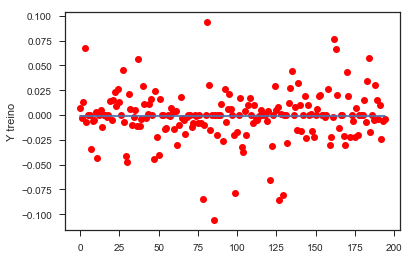

In [36]:
mediaY = np.mean(Y_train)
Ypred1 = [mediaY] * len(Y_train)
print('Média (μ) = ' + "{:.8f}".format(mediaY))

#Plotar Gráfico
fig = plt.figure()
ax = plt.axes()
ax.plot(Xn, Y_train, 'ro')
ax.plot(Xn, Ypred1)
plt.ylabel('Y treino')
plt.show()

Podemos observar que nossa média foi extremamente baixa, mas ainda não podemos concluir nada acerca de seu desempenho. Relembramos apenas que este modelo é extremamente simples, então muitas vezes não é o mais adequado.

<a id='itemC2'></a>
### C.2) __Modelo de Regressão Linear Múltipla (Multiple Linear Regression)__

Este modelo se trata de uma coleção de técnicas estatísticas para construir modelos que descrevem razoávelmente as relações entre as variáveis explicativas de um determinado processo. A diferença entre a regressão linear simples e a linear múltipla é que na múltipla são usadas duas ou mais variáveis explicativas. 
Este modelo se dá pela seguinte fórmula:

$$\hat{y}(t)=\beta_{0}+ \beta_{1}x_{1}+ \beta_{2}x_{2} + \cdots + \beta_{8}x_{8}+ \epsilon_{i}$$

Em que:

$\beta_{i}$ é o coeficiente;

$\epsilon_{i}$ é o erro aleatório da medida i;

$\hat{y}(t)$ é o valor de y previsto no 'instante' i.

In [37]:
Xreg = sm.add_constant(X_train)
model = sm.OLS(Y_train,Xreg)
results = model.fit()
Ypred2 = results.predict(Xreg)
Ypred22 = results.predict(sm.add_constant(X_test))

Como nossos valor-p é maior que 5% para todas as variáveis, não rejeitamos nenhuma hipótese para este níel de significância

* Como nosso R² ajustado (Adj-R-squared) é muito baixo esse modelo não consegue explicar com eficiência a variabilidade dos dados.
* Como __Prob(Omnibus)__ é zero e __Prob(JB)__ tende à zero, há grande evidência que os resíduos não são distribuídos de forma normal, violando a suposição do modelo de regressão.
* O __Durbin-Watson__ próximo de 2 sugere que não há autocorrelação dos resíduos

<a id='itemC3'></a>
### C.3) Modelo de Regressão dos K Vizinhos Mais Próximos (K-Nearest Neighbors Regression)

O modelo de Regressão dos K Vizinhos Mais Próximos é utilizado para determinar uma classificação de uma amostra baseada nas amostras vizinhas que estão presentes em um conjunto Treinamento. Essa classificação se dá pelo cálculo da distância euclidiana e a variável K representa a quantidade de vizinhos mais próximos que serão utilizados para determinar qual classe a nova amostra pertence.

Utilizaremos um k = 11.

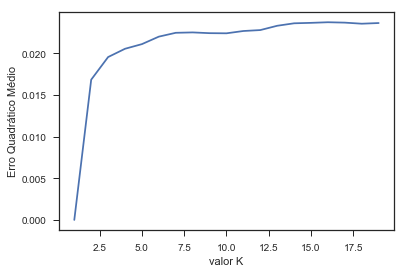

In [39]:
Yk = []
listaK = range(1,20)
erro=[]
for k in listaK:
    clf=KNeighborsRegressor(k)
    clf.fit(X_train,Y_train)
    y_pred=list(clf.predict(X_train))
    RMSmodelo = rms(Y_train,y_pred)
    Yk.append(RMSmodelo)
    
plt.plot(listaK, Yk)
plt.xlabel('valor K')
plt.ylabel('Erro Quadrático Médio')
plt.show()

O Erro Quadrático Médio se mantém praticamente constante a partir de K igual 10. Prevendo os valores para K=10:

In [40]:
clf=KNeighborsRegressor(10)
clf.fit(X_train,Y_train)
Ypred3=clf.predict(X_train)
Ypred33=clf.predict(X_test)

<a id='itemC4'></a>
### C.4) Modelo de Árvores de Regressão (Decision Tree Regression)

O modelo de Árvores de regressão são similares às árvores de decisão, pois são formadas por nós. Estes nós foram definidos por atributos baseados no nosso problema. Já as arestas indicam quais devem ser percorridas até alcançar uma folha contendo uma predição. A maior diferença entre as árvores de desição e de regressão é que, ao alcançarmos um nó sem filhos, o resultado obtido é um escalar, e não uma classificação.

In [42]:
regressor = DecisionTreeRegressor()
regressor.fit(X_train, Y_train)
Ypred4 = regressor.predict(X_train)
Ypred44 = regressor.predict(X_test)

<a id='itemD'></a>
___

## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

In [52]:
listaRMS, listaR2 = [], []
for i in [Ypred1, Ypred2, Ypred3, Ypred4]:
    listaRMS.append(rms(Y_train,i))
    listaR2.append(R2(Y_train,i))

In [53]:
dados = pd.DataFrame(data={'RMS': listaRMS, 'R2': listaR2})
dados.index = ['Predição pela média', 'Regressão Linear Múltipla','Regressão dos K vizinhos','Árvore de Regressão']
dados

,RMS,R2
Predição pela média,0.025175,0.000000
Regressão Linear Múltipla,0.023966,0.093699
Regressão dos K vizinhos,0.022413,0.207355
Árvore de Regressão,0.000068,0.999993


__teste__

In [54]:
listaRMStest, listaR2test = [], []
for i in [Ypred22, Ypred33, Ypred44]:
    listaRMStest.append(rms(Y_test,i))
    listaR2test.append(R2(Y_test,i))

dados = pd.DataFrame(data={'RMS': listaRMStest, 'R2': listaR2test})
dados.index = ['Regressão Linear Múltipla','Regressão dos K vizinhos','Árvore de Regressão']
dados

,RMS,R2
Regressão Linear Múltipla,0.033820,0.002035
Regressão dos K vizinhos,0.036016,-0.131716
Árvore de Regressão,0.038904,-0.320494


Nessa etapa do trabalho calculamos para as duas amostras (teste e treinamento) os tipos de regressão. No primeiro momento utilizamos a amostra treinamento para ensinar à máquina como aplicar o modelo. Em cada um foram calculados o coeficiente de determinação (R2) e raiz do erro médio quadrático (RMS). Após o treinamento ensinamos a máquina a prever os valores para os modelos. <br> 
Observamos que o modelo de Árvore de Regressão obteve um RMS baixo no treinamento mas não no treino, isso quer dizer que o modelo ficou muito especializado, ou seja, tinha muito overfitting. Já as outras duas regressões tiverem RMS semelhantes. Como a regressão linear múltipla obteve um erro menor, concluimos que dentre estes modelos ele foi o que melhor previu.

<a id='itemE'></a>
___

## E. CONCLUSÃO

<br> Com o propósito de prever o preço do Iphone X através do retorno do dólar e de outros 7 aparelhos escolhidos disponíveis no mercado no último ano, observamos que apesar do erro quadrático médio não ter sido tão ruim (próximo a 0), o coeficiente de determinação nos prova que os modelos escolhidos não se ajustaram (deveriam estar próximos de 1). O modelo que melhor se adequou ao trabalho, foi o de regressão linear múltipla pelo fato da diferença entre os resultados de treinamento e teste terem sido semelhantes. Já o modelo de K vizinhos mais próximo também se adequou bem, mas possui uma maior diferença quando comparamos os resultados da amostra treinamento com a amostra teste.
Devemos ressaltar também as correlações entre os aparelhos e o dólar, pois observando a matriz presente no Item B, vemos que a correlação é extremamente baixa e as únicas que se destacaram foram entre Iphone 7 e Iphone 7 Plus e Samsung S9 e Samsung S9 Plus, que devem ter se dado pelo fato de serem aparelhos semelhantes que só variam de tamanho. 
Portanto, concluimos que prever o preço do Iphone X não depende expecificamente da variação do dólar e nem da variação do preço de outros celulares considerados concorrentes a este. Para futuras interações poderiam ser usados modelos mais complexos que considerassem, por exemplo, que há um intervalo de tempo (delay) para a variável resposta "sentir" a variação do preço do dólar. <br>

<a id='itemF'></a>
___

## F. REFERÊNCIAS BIBLIOGRÁFICAS

________
https://www.buscape.com.br $\rightarrow$ site para busca de histórico dos preços

https://ensinandomaquinasblog.wordpress.com/2017/12/15/modelos-preditivos-de-notas-de-redacao-do-enem-2015

https://educationalresearchtechniques.com/2018/11/02/k-nearest-neighbor-regression-with-python//